In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
trainX = np.load("/content/gdrive/MyDrive/archive/ProcessedData/trainX.npy").astype(np.float32)
trainY = np.load("/content/gdrive/MyDrive/archive/ProcessedData/trainY.npy").astype(np.float32)
testX = np.load("/content/gdrive/MyDrive/archive/ProcessedData/testX.npy").astype(np.float32)
testY = np.load("/content/gdrive/MyDrive/archive/ProcessedData/testY.npy").astype(np.float32)

# allX = np.load("/content/gdrive/MyDrive/archive/ProcessedData/allX.npy").astype(np.float32)
# allY = np.load("/content/gdrive/MyDrive/archive/ProcessedData/allY.npy").astype(np.float32)

In [4]:
trainX.shape

(180, 512, 512)

In [5]:
testX.shape

(46, 512, 512)

In [6]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [7]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


In [8]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (180, 512, 512, 1)
trainY: (180, 512, 512, 1)
testX: (46, 512, 512, 1)
testY: (46, 512, 512, 1)


In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)

    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
weight_path="checkpoint-{epoch:03d}-{val_dice_coef:.3f}.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                   patience=2,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=18)

CALLBACKS = [checkpoint, early, reduceLROnPlat]

In [12]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 16,
                    epochs = 100,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.4750 - dice_coef: 0.0015 - loss: -0.0015
Epoch 1: val_loss improved from inf to -0.00198, saving model to checkpoint-001-0.002.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - binary_accuracy: 0.4960 - dice_coef: 0.0015 - loss: -0.0015 - val_binary_accuracy: 0.9906 - val_dice_coef: 0.0020 - val_loss: -0.0020 - learning_rate: 2.0000e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - binary_accuracy: 0.9896 - dice_coef: 0.0015 - loss: -0.0015
Epoch 2: val_loss improved from -0.00198 to -0.00219, saving model to checkpoint-002-0.002.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - binary_accuracy: 0.9896 - dice_coef: 0.0015 - loss: -0.0015 - val_binary_accuracy: 0.9881 - val_dice_coef: 0.0022 - val_loss: -0.0022 - learning_rate: 2.0000e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - binary_accuracy: 0.9866 - dice_coef: 0.0018 - loss: -0.0018
Epoch 3: val_loss improved from -0.00219 to -0.0031

continue training (Use part 1 code to generate more data)

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy'])
model.load_weights("/content/gdrive/MyDrive/archive/Training_Logs/UNet_best_Model_checkpoint.h5")


In [ ]:
history = model.fit(         x = trainX,
                    y = trainY,
                    batch_size = 16,
                    epochs = 100,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - binary_accuracy: 0.9990 - dice_coef: 0.2280 - loss: -0.2278
Epoch 1: val_loss improved from inf to -0.28491, saving model to checkpoint-001-0.285.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 253s 14s/step - binary_accuracy: 0.9990 - dice_coef: 0.2328 - loss: -0.2324 - val_binary_accuracy: 0.9987 - val_dice_coef: 0.2845 - val_loss: -0.2849 - learning_rate: 2.0000e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - binary_accuracy: 0.9988 - dice_coef: 0.3354 - loss: -0.3357
Epoch 2: val_loss improved from -0.28491 to -0.36361, saving model to checkpoint-002-0.362.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.9988 - dice_coef: 0.3386 - loss: -0.3391 - val_binary_accuracy: 0.9989 - val_dice_coef: 0.3617 - val_loss: -0.3636 - learning_rate: 2.0000e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9992 - dice_coef: 0.4752 - loss: -0.4757
Epoch 3: val_loss did not improve from -0.36361
12/12 

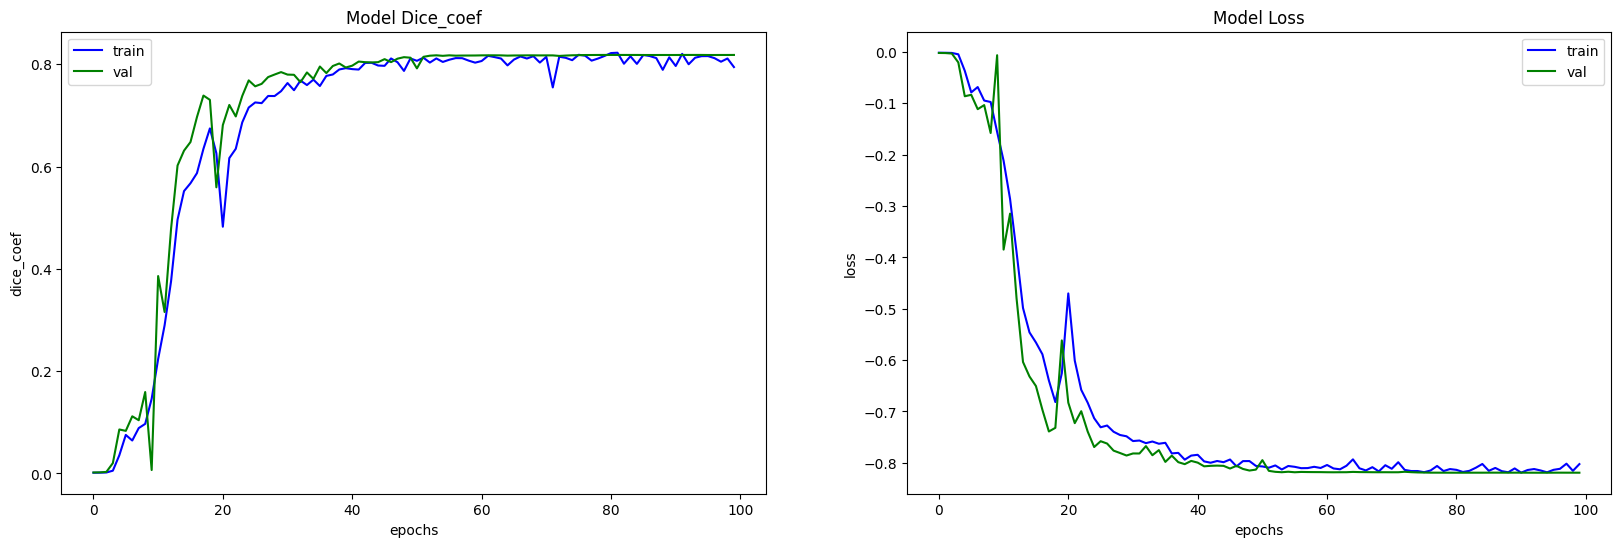

In [14]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:
import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
model.save("UNet.h5")

In [ ]:
model.evaluate(testX, testY)

2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 269ms/step - binary_accuracy: 0.9996 - dice_coef: 0.7492 - loss: -0.7247


[-0.7462853789329529, 0.7830456495285034, 0.9996229410171509]

In [ ]:
model2 = unet(input_size=(512,512,1))
model2.load_weights("/content/checkpoint-082-0.751.weights.h5")

model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

model2.evaluate(testX, testY)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 691ms/step - binary_accuracy: 0.9996 - dice_coef: 0.7496 - loss: -0.7256


[-0.7467472553253174, 0.7827194929122925, 0.9996211528778076]

In [ ]:
model2.save("UNet_best_Model1_checkpoint.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


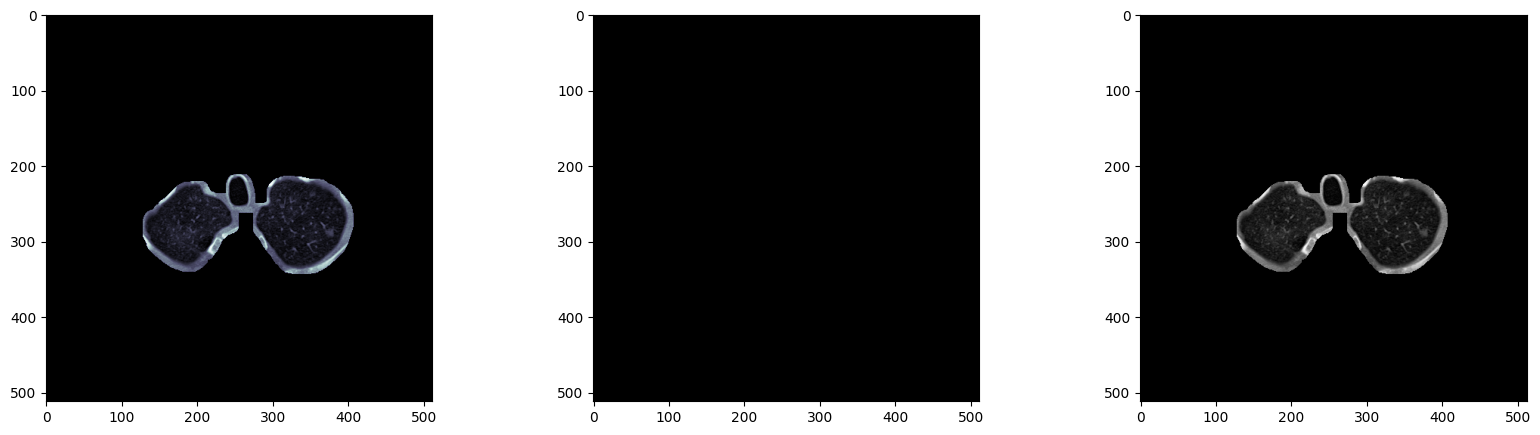

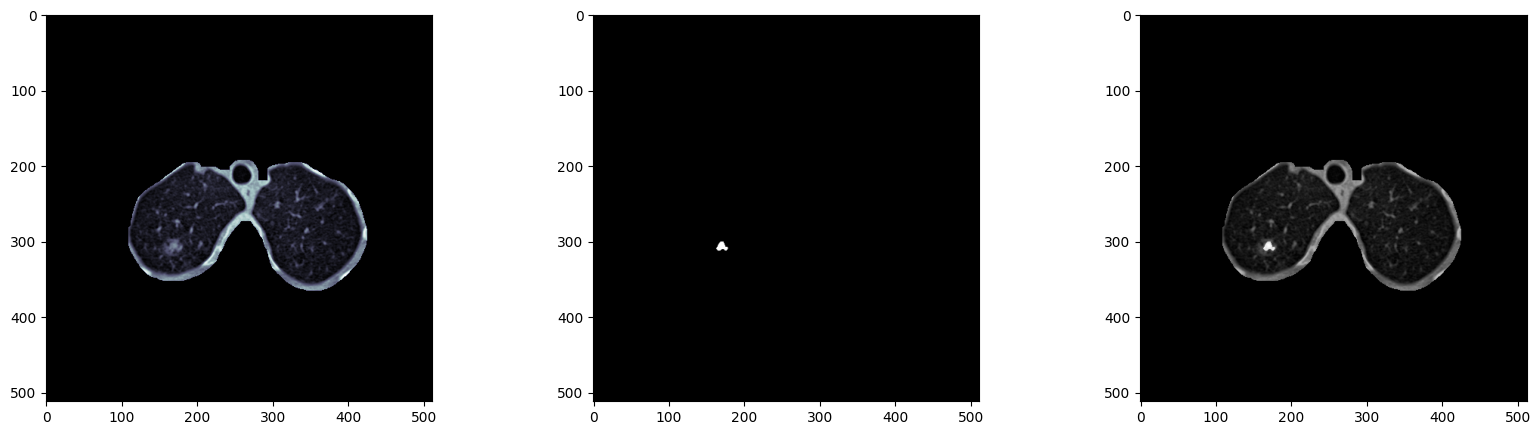

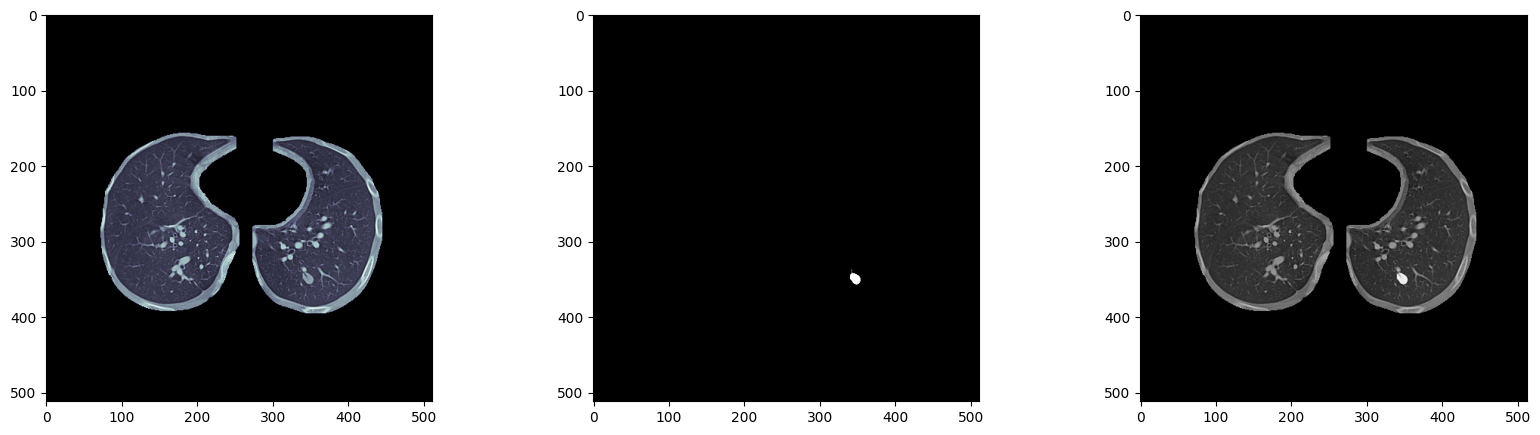

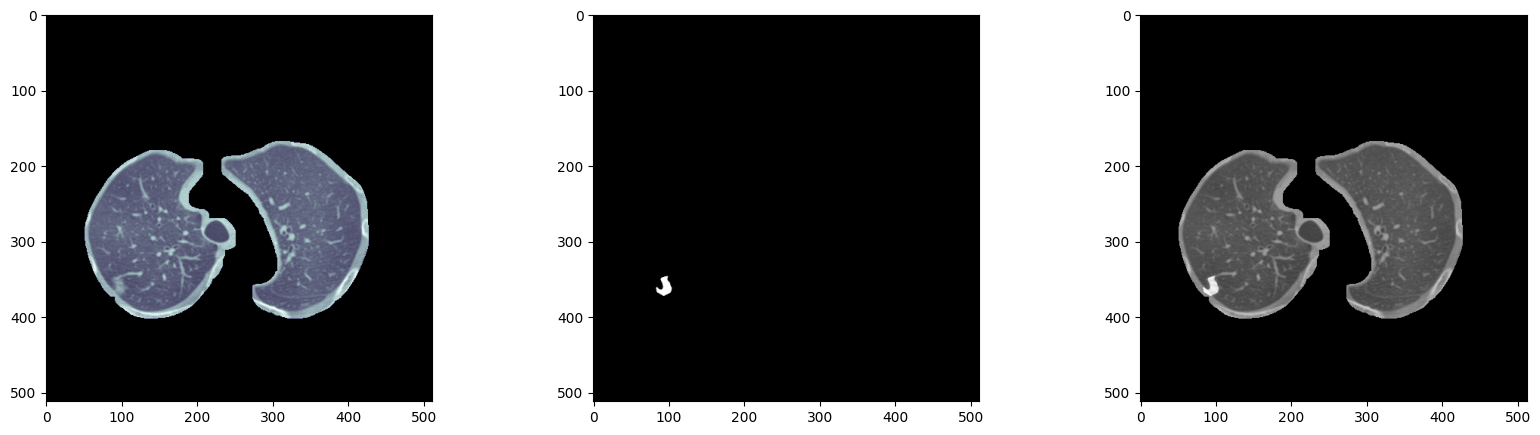

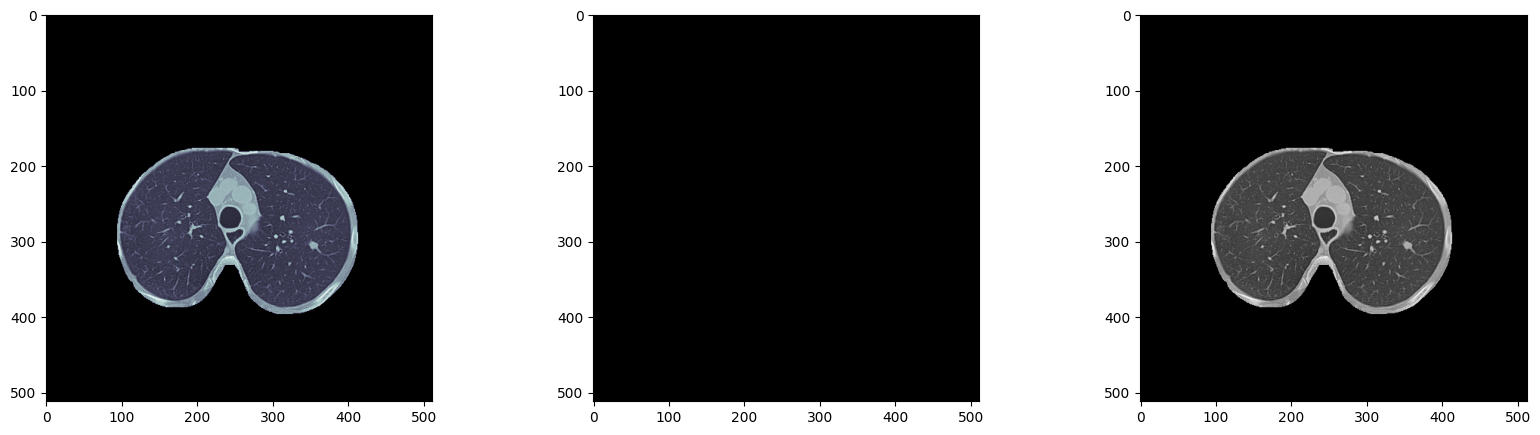

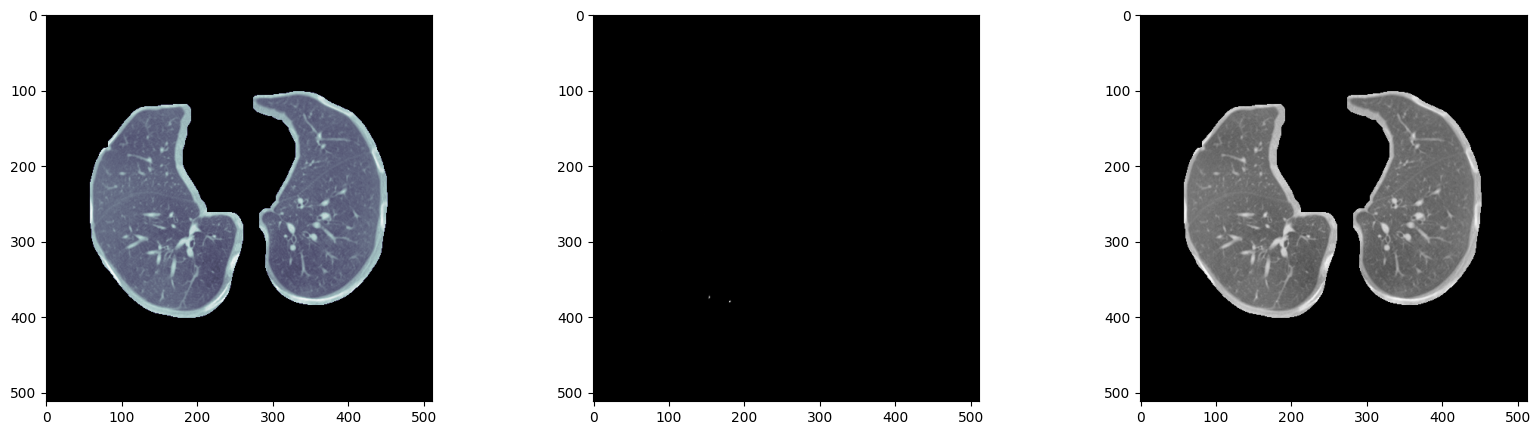

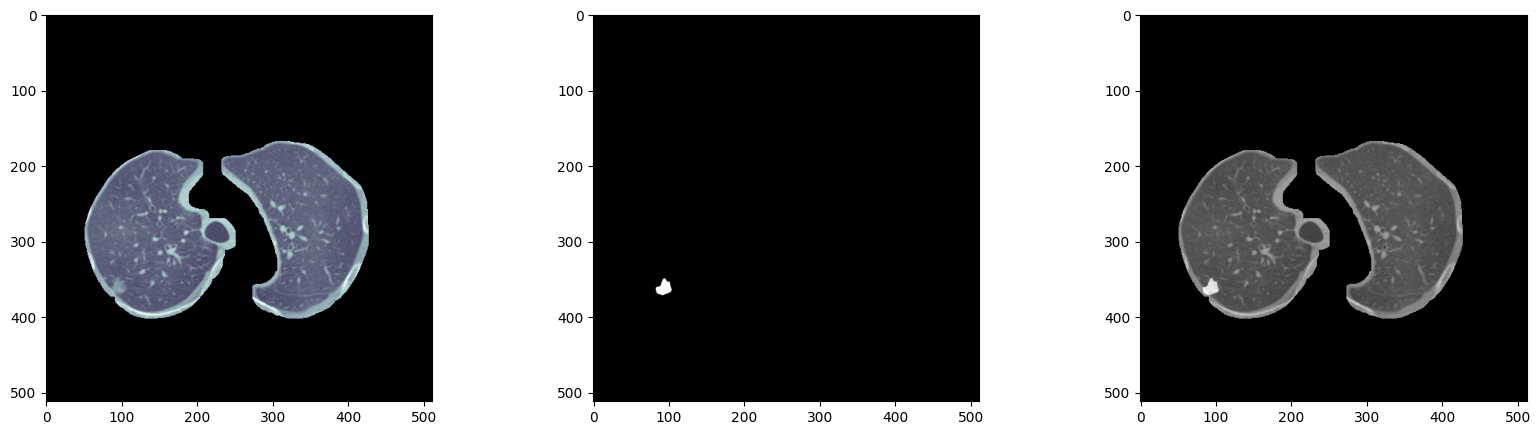

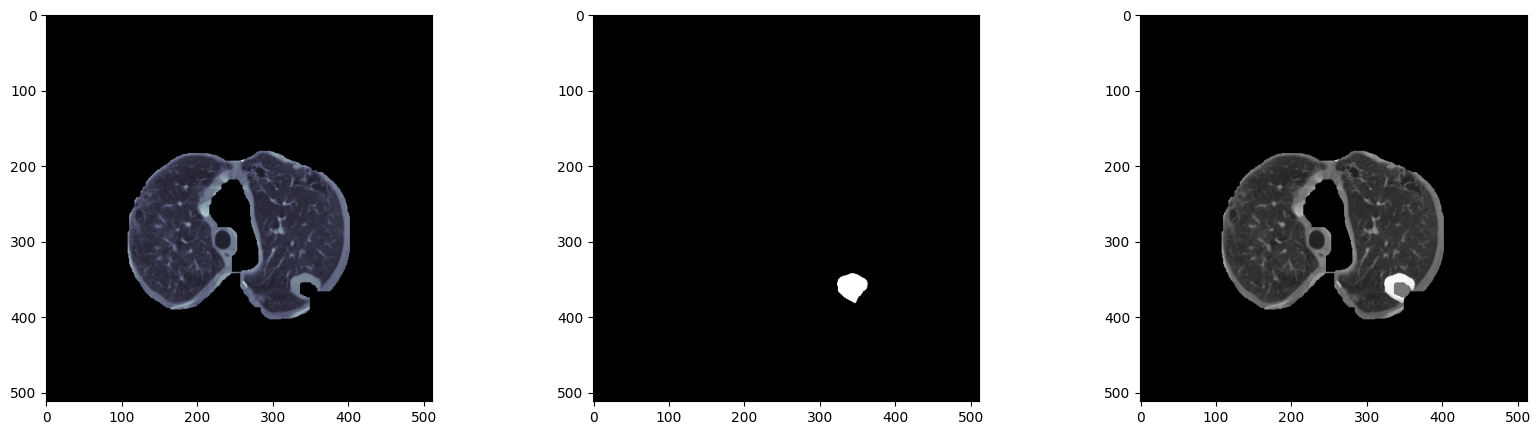

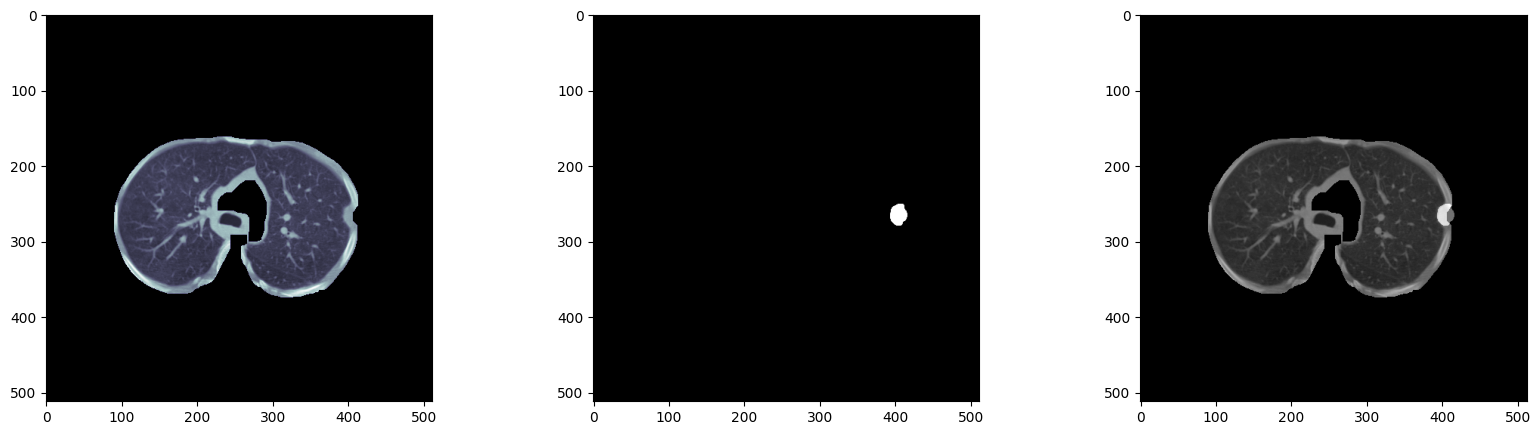

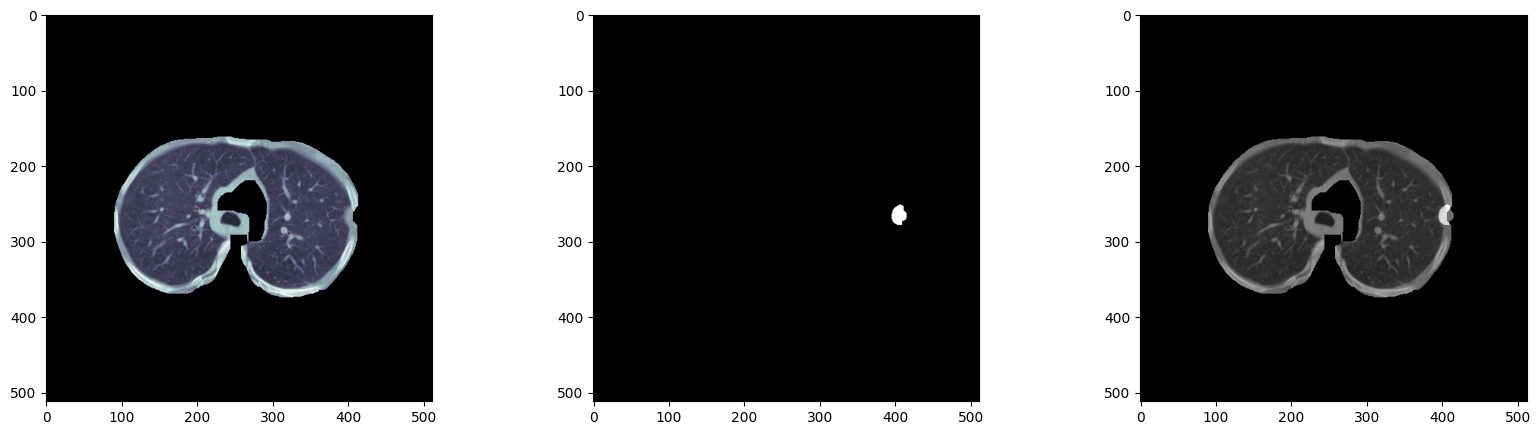

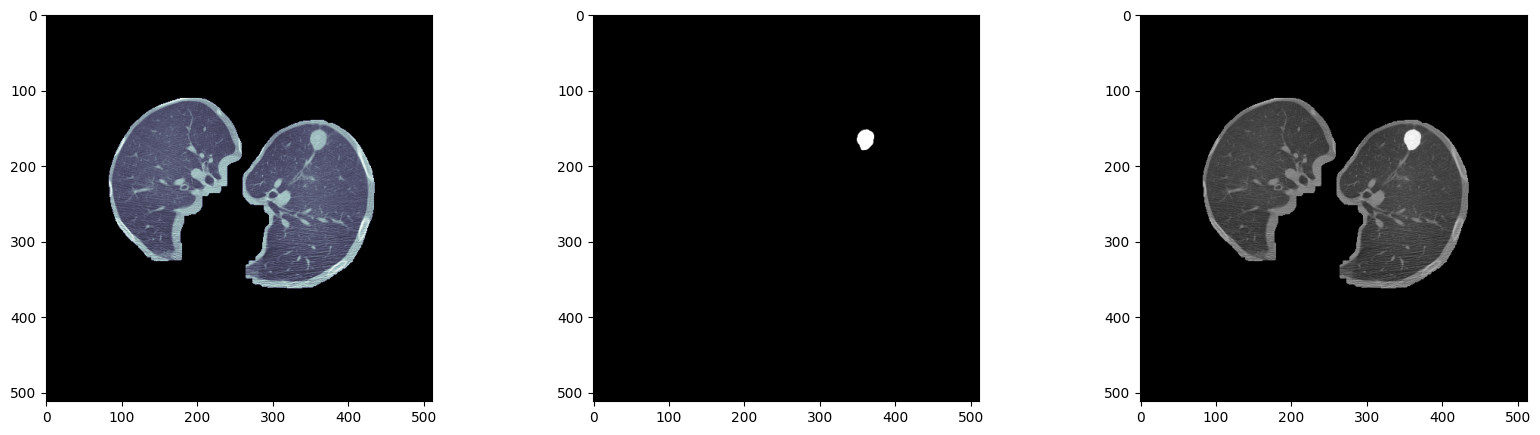

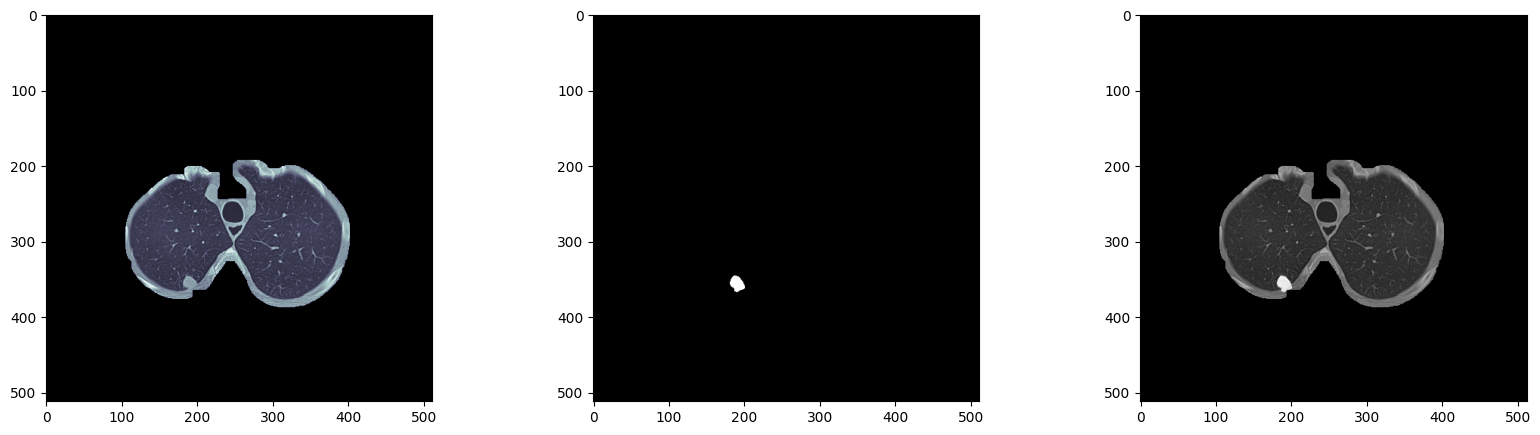

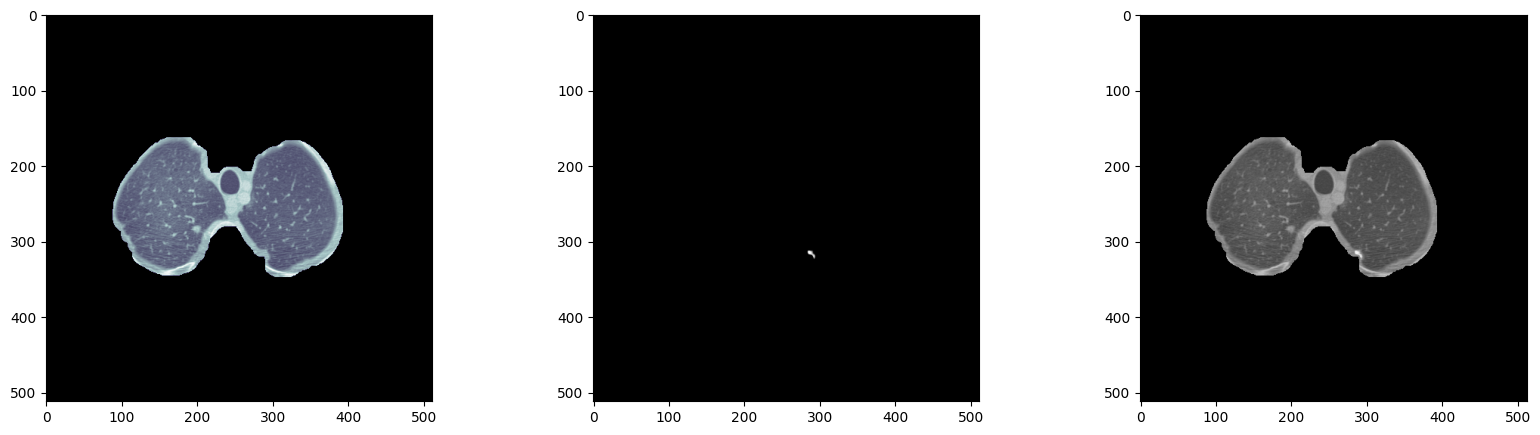

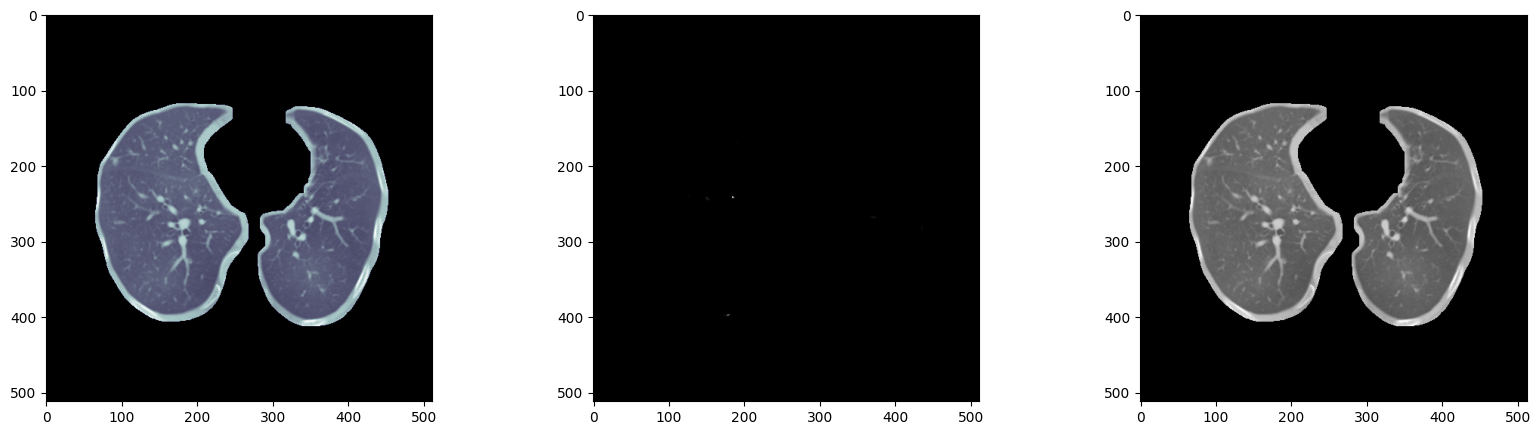

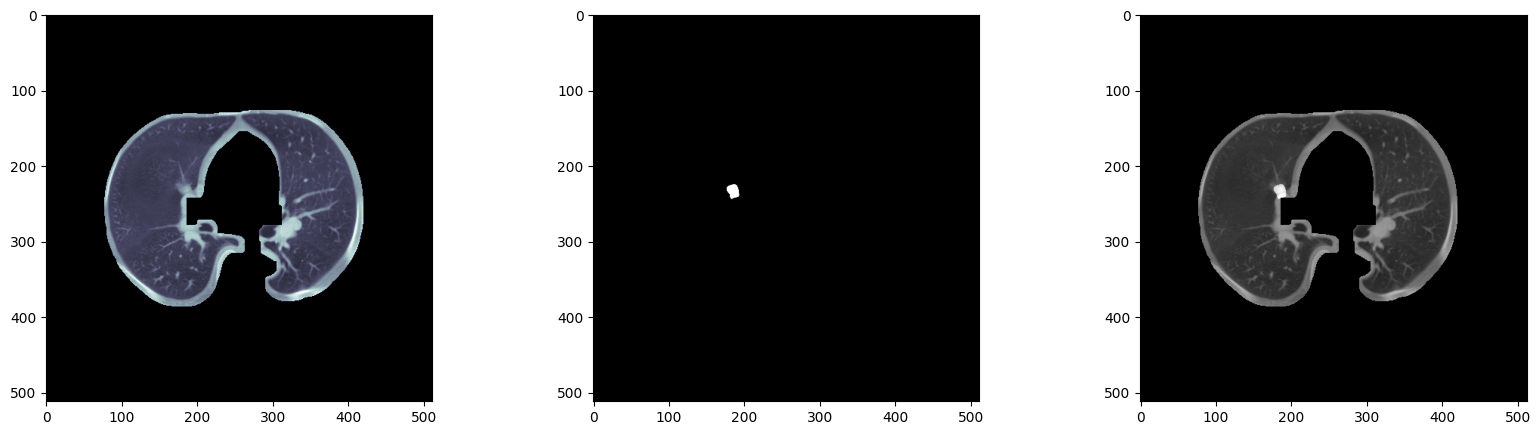

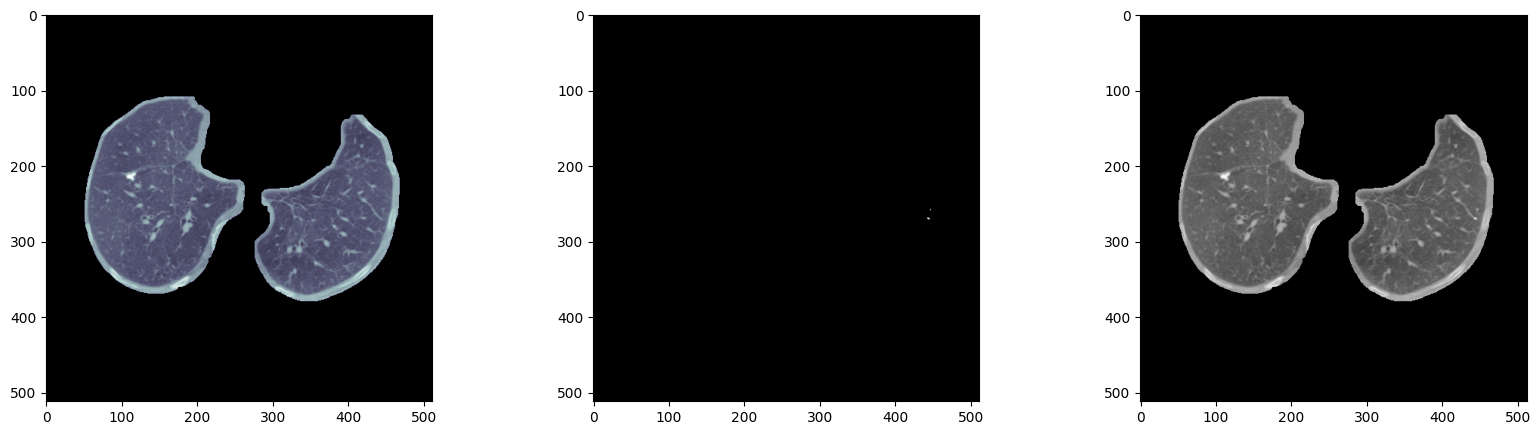

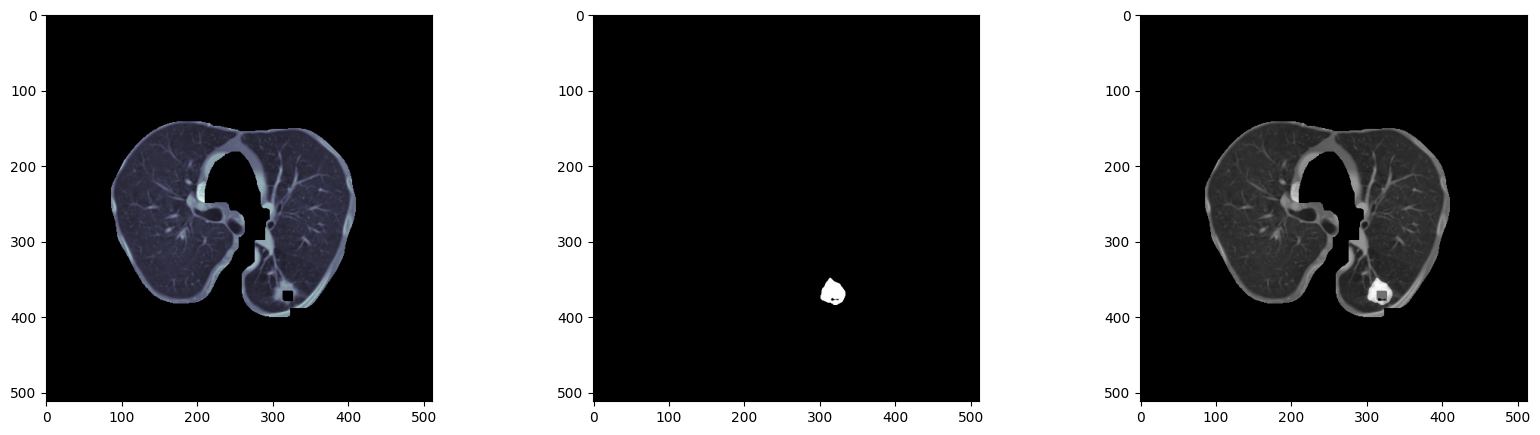

In [ ]:
j = 1
for i in range(30, min(80, len(testX))):  # Adjust the loop range
    test = np.squeeze(testX)[i]
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))

    plt.figure(figsize=(20, 300))
    plt.subplot(50, 3, j)
    plt.imshow(np.squeeze(test), cmap="bone")
    plt.subplot(50, 3, j + 1)
    plt.imshow(np.squeeze(t_p), cmap="gray")
    plt.subplot(50, 3, j + 2)
    plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
    j += 3


In [ ]:
!cp UNet.h5 /content/gdrive/MyDrive/archive/Training_Logs/UNet.h5
!cp LC_UNet_trainHistory /content/gdrive/MyDrive/archive/Training_Logs/UNet_trainHistory

In [ ]:
!cp UNet_best_Model_checkpoint.h5 /content/gdrive/MyDrive/archive/Training_Logs/UNet_best_Model_checkpoint.h5

cp: cannot stat 'UNet_best_Model_checkpoint.h5': No such file or directory


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

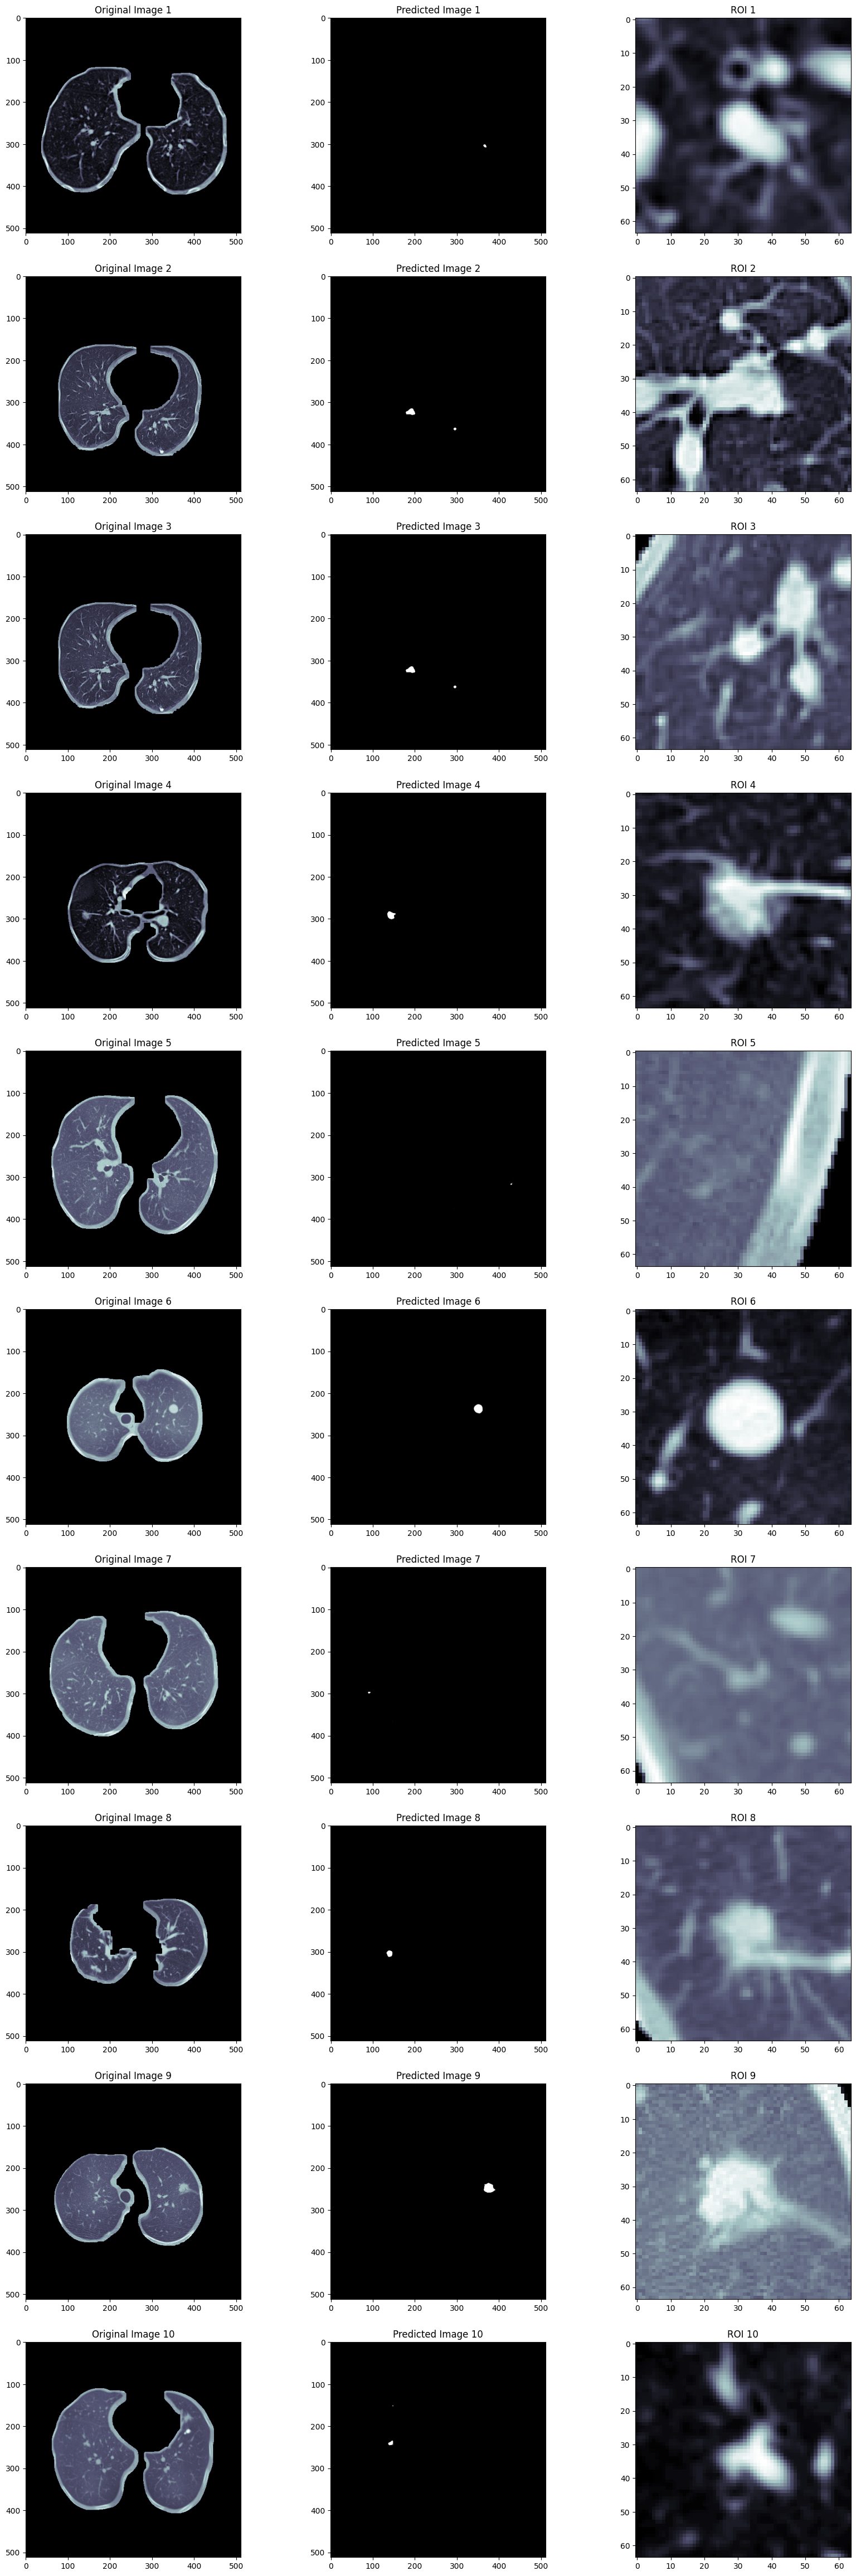

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label


all_rois = []

# target size
target_size = (64, 64)
# every image in train X
for i in range(len(testX)):
    test = np.squeeze(testX)[i]
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))


    t_p = np.squeeze(t_p)

    binary_t_p = (t_p >= 0.1).astype(np.uint8)
    # skip empty t_p
    if np.all(binary_t_p == 0):
        continue

    # mark every non-zero region
    labeled_array, num_features = label(binary_t_p)

    # check the size of non-zero region
    for region in range(1, num_features + 1):
        region_mask = (labeled_array == region)
        if np.sum(region_mask) < 15:  # set threshold
            continue

        y_indices, x_indices = np.nonzero(region_mask)
        x1, x2 = x_indices.min()-20, x_indices.max() + 20
        y1, y2 = y_indices.min()-20, y_indices.max() + 20

        # extract ROI from oringinal image
        roi = test[y1:y2, x1:x2]

        # resize ROI
        resized_roi = cv2.resize(roi, target_size)

        # append resized ROI into list
        all_rois.append((test, t_p, resized_roi))

# print the number of ROIs
print(f"Total number of ROIs extracted and resized: {len(all_rois)}")

# show 10 ROI
plt.figure(figsize=(20, 300))
for idx in range(min(10, len(all_rois))):
    original_image, predicted_image, roi_image = all_rois[idx]

    plt.subplot(50, 3, idx * 3 + 1)
    plt.imshow(original_image, cmap="bone")
    plt.title(f"Original Image {idx + 1}")

    plt.subplot(50, 3, idx * 3 + 2)
    plt.imshow(predicted_image, cmap="gray")
    plt.title(f"Predicted Image {idx + 1}")

    plt.subplot(50, 3, idx * 3 + 3)
    plt.imshow(roi_image, cmap="bone")
    plt.title(f"ROI {idx + 1}")

plt.show()


Get ROIs(nodules) image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


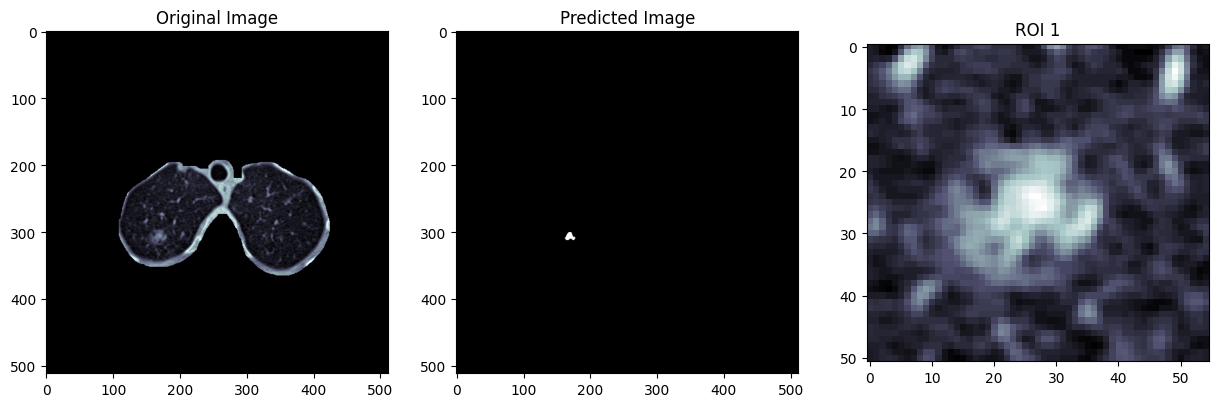

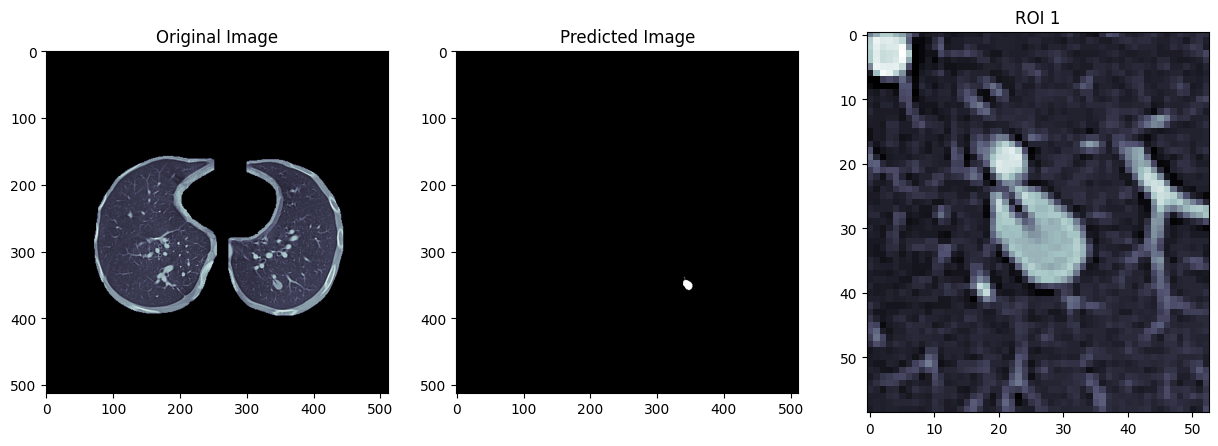

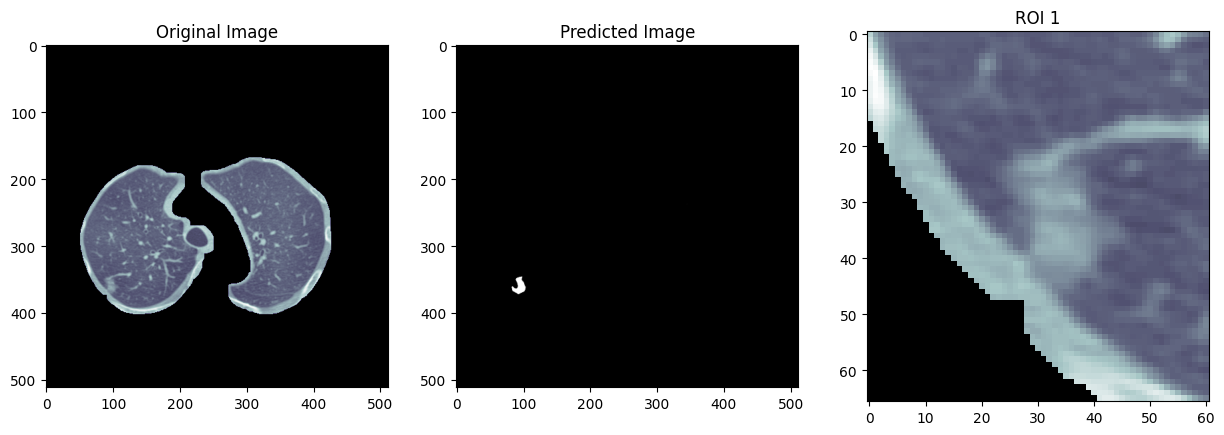

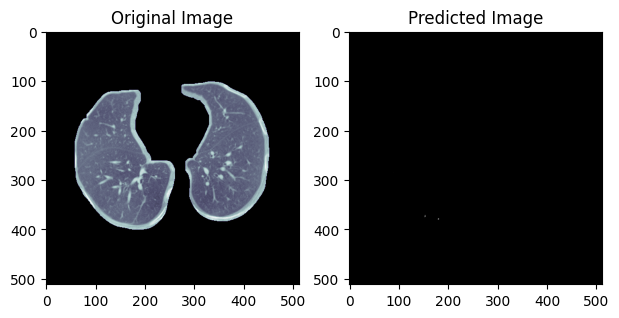

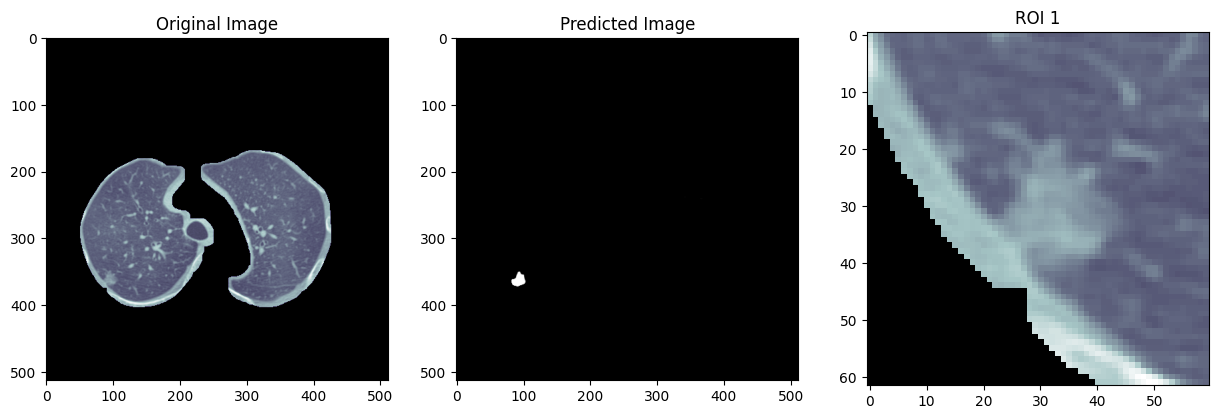

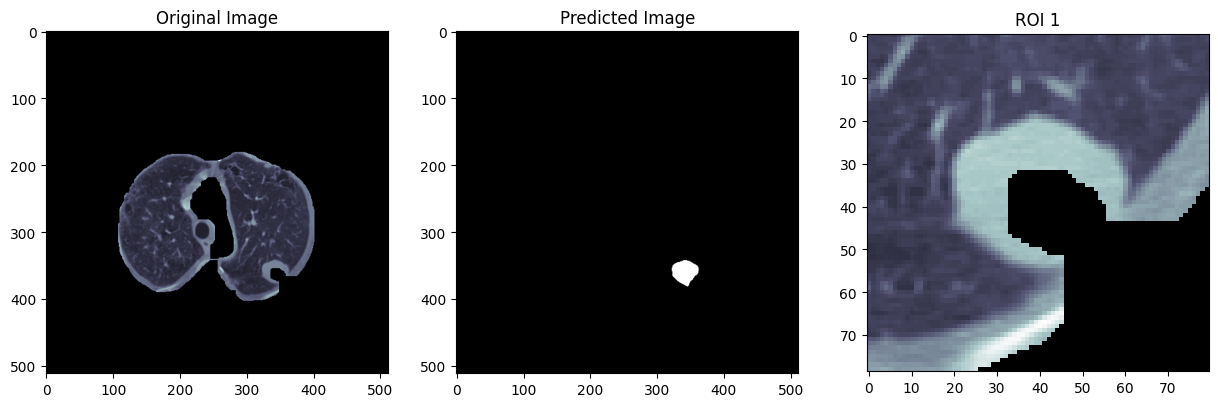

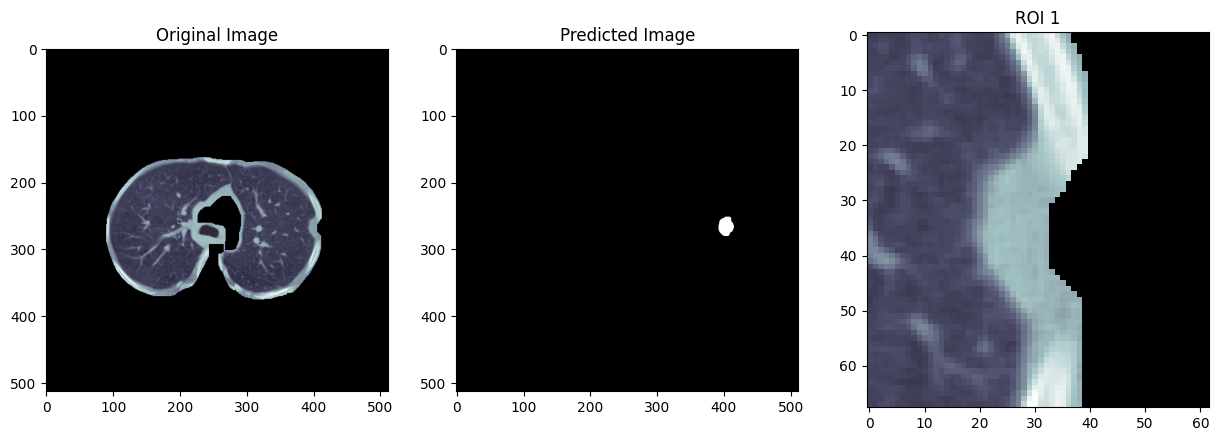

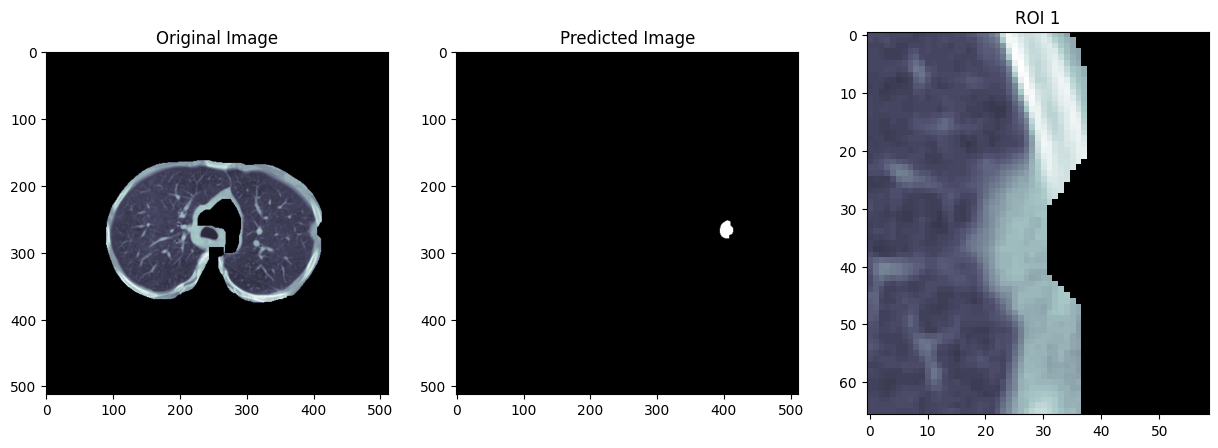

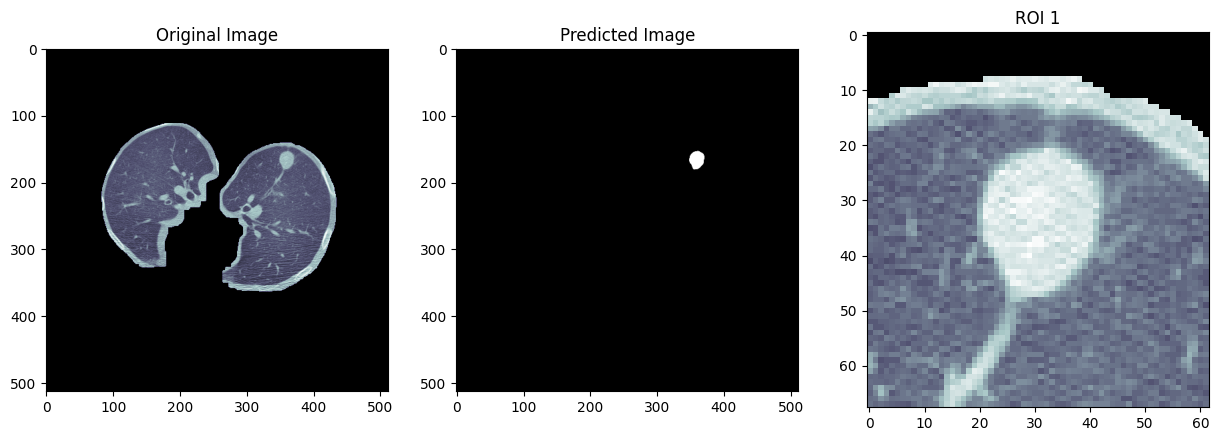

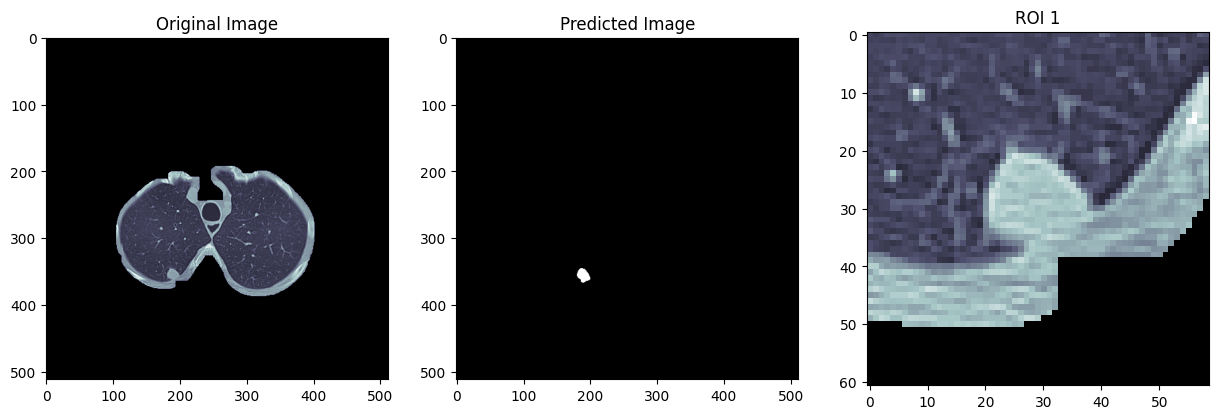

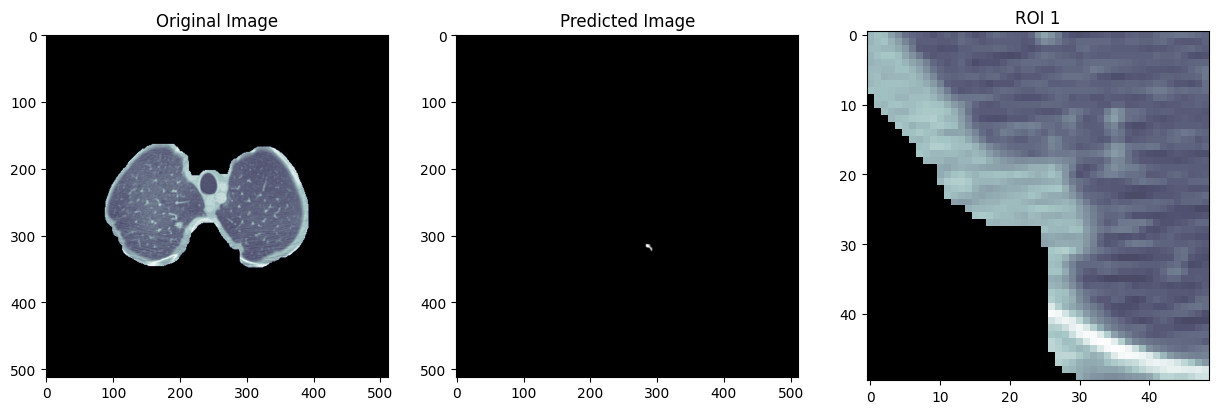

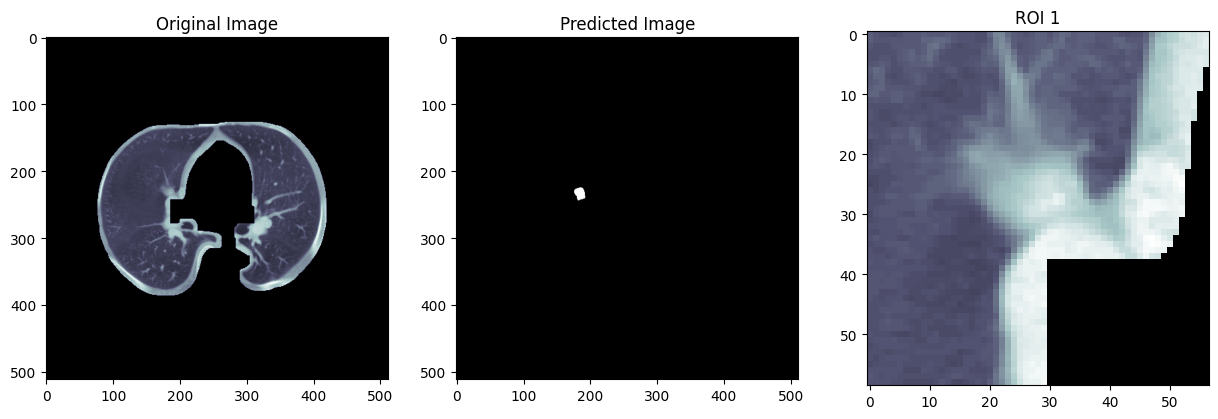

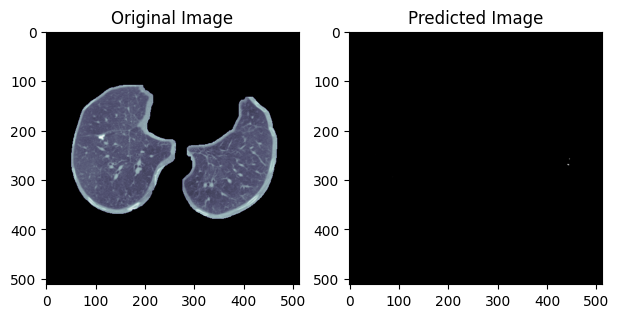

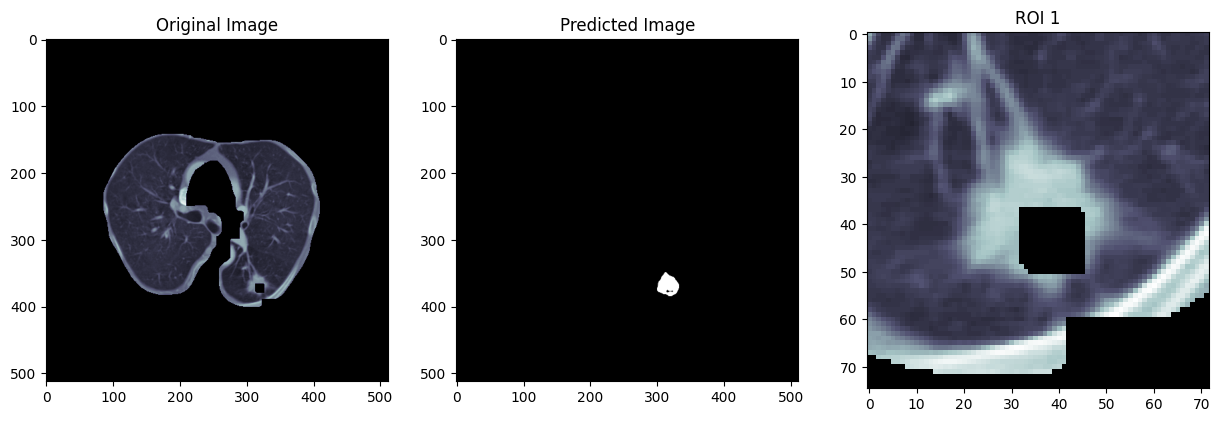

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

j = 1
target_size = (64, 64)

for i in range(30, min(80, len(testX))):
    test = np.squeeze(testX)[i]
    t_p = model2.predict(np.reshape(test, (1, 512, 512, 1)))

    t_p = np.squeeze(t_p)

    binary_t_p = (t_p >= 0.1).astype(np.uint8)

    if np.all(binary_t_p == 0):
        continue

    labeled_array, num_features = label(binary_t_p)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_features + 2, 1)
    plt.imshow(np.squeeze(test), cmap="bone")
    plt.title("Original Image")

    plt.subplot(1, num_features + 2, 2)
    plt.imshow(np.squeeze(t_p), cmap="gray")
    plt.title("Predicted Image")


    for region in range(1, num_features + 1):
        region_mask = (labeled_array == region)
        if np.sum(region_mask) < 15:
            continue

        y_indices, x_indices = np.nonzero(region_mask)
        x1, x2 = x_indices.min()-20, x_indices.max() + 20
        y1, y2 = y_indices.min()-20, y_indices.max() + 20


        roi = test[y1:y2, x1:x2]
        resized_roi = cv2.resize(roi, target_size)

        plt.subplot(1, num_features + 2, region + 2)
        plt.imshow(roi, cmap="bone")
        plt.title(f"ROI {region}")

    j += num_features + 2

plt.show()